In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Chargement data
data = pd.read_csv('../data/raw/data_brut.csv', parse_dates=['date'], index_col='date', usecols=['date', 'meantemp'])

print(data)

             meantemp
date                 
2013-01-01  10.000000
2013-01-02   7.400000
2013-01-03   7.166667
2013-01-04   8.666667
2013-01-05   6.000000
...               ...
2016-12-28  17.217391
2016-12-29  15.238095
2016-12-30  14.095238
2016-12-31  15.052632
2017-01-01  10.000000

[1462 rows x 1 columns]


In [2]:
# Affichage data
print(data.head())

             meantemp
date                 
2013-01-01  10.000000
2013-01-02   7.400000
2013-01-03   7.166667
2013-01-04   8.666667
2013-01-05   6.000000


In [3]:
# info dataset
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meantemp  1462 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB
None
          meantemp
count  1462.000000
mean     25.495521
std       7.348103
min       6.000000
25%      18.857143
50%      27.714286
75%      31.305804
max      38.714286


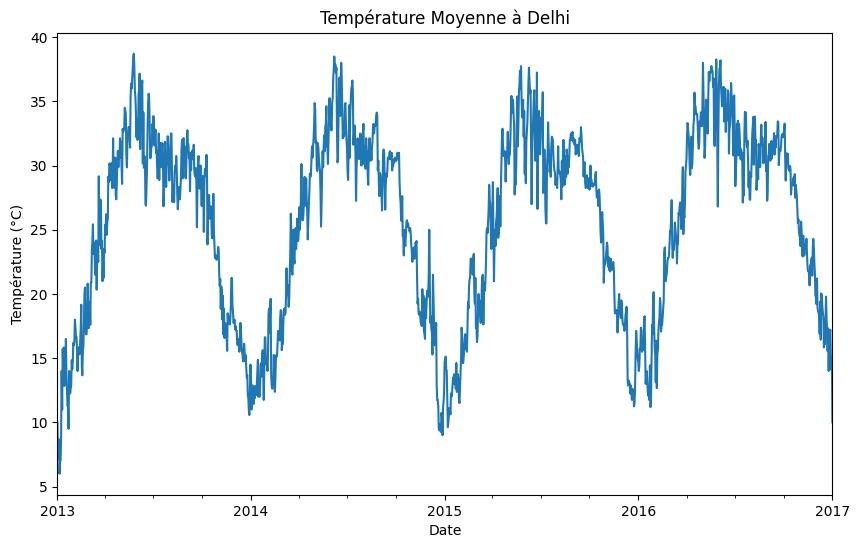

In [6]:
# Tracer la température moyenne sur le temps
data['meantemp'].plot(figsize=(10, 6))
plt.title('Température Moyenne à Delhi')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.show()

In [7]:
# Stationarité
from statsmodels.tsa.stattools import adfuller

# Tester la stationnarité de la série
def test_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print("La série est stationnaire")
    else:
        print("La série n'est pas stationnaire, différenciation nécessaire")

# Appliquer le test ADF sur la température
test_stationarity(data['meantemp'])

ADF Statistic: -2.021069
p-value: 0.277412
La série n'est pas stationnaire, différenciation nécessaire


In [8]:
# différenciation pour rende la série stationnaire
data['diff_meantemp'] = data['meantemp'].diff()
print(data['diff_meantemp'])

date
2013-01-01         NaN
2013-01-02   -2.600000
2013-01-03   -0.233333
2013-01-04    1.500000
2013-01-05   -2.666667
                ...   
2016-12-28    0.367391
2016-12-29   -1.979296
2016-12-30   -1.142857
2016-12-31    0.957393
2017-01-01   -5.052632
Name: diff_meantemp, Length: 1462, dtype: float64


In [9]:
# je reteste avec nettiyage valeur nulle
test_stationarity(data['diff_meantemp'].dropna())

ADF Statistic: -16.378720
p-value: 0.000000
La série est stationnaire


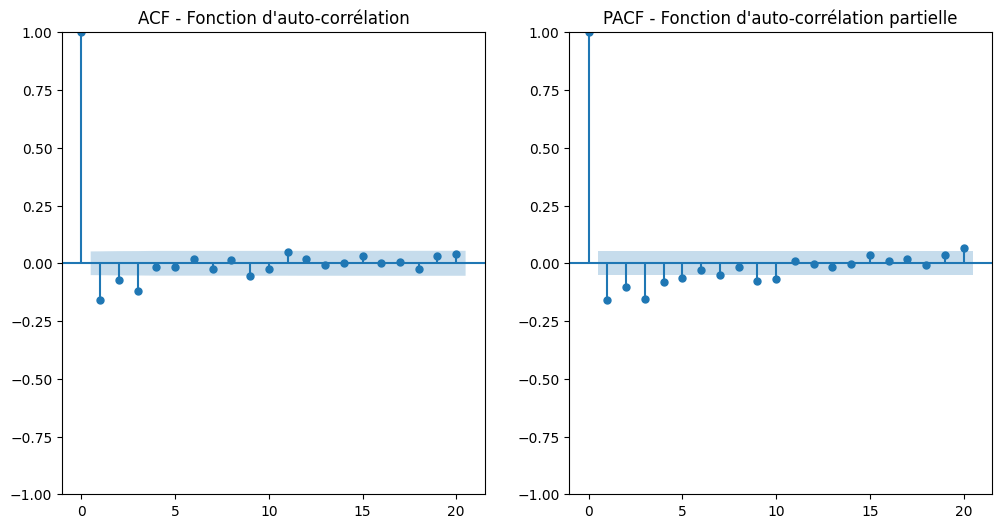

In [10]:
# Tracer ACF et PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data['diff_meantemp'].dropna(), lags=20, ax=plt.gca())
plt.title('ACF - Fonction d\'auto-corrélation')

plt.subplot(122)
plot_pacf(data['diff_meantemp'].dropna(), lags=20, ax=plt.gca())
plt.title('PACF - Fonction d\'auto-corrélation partielle')

plt.show()

In [12]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Trouver le meilleur modèle ARIMA avec auto_arima
model = auto_arima(data['meantemp'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Afficher le résumé du modèle
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5546.314, Time=2.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5650.181, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5614.068, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5602.114, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5648.181, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5546.168, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5573.723, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5544.460, Time=1.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5546.100, Time=1.82 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5600.849, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5542.478, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5600.115, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5612.068, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5544.118, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [13]:
# Ajuster le modèle ARIMA sur les données originales
model.fit(data['meantemp'])

# Faire une prédiction pour une date future (par exemple, 2013-01-18)
forecast = model.predict(n_periods=1)
print(f"Prévision de température pour le 2013-01-18 : {forecast[0]}°C")


Prévision de température pour le 2013-01-18 : 11.354415307193243°C


In [14]:
# Prédiction avec intervalle de confiance
forecast, conf_int = model.predict(n_periods=1, return_conf_int=True)

# Afficher la prévision et l'intervalle de confiance
print(f"Prévision de température pour le 2013-01-18 : {forecast[0]}°C")
print(f"Intervalle de confiance à 95% : {conf_int[0]}")

Prévision de température pour le 2013-01-18 : 11.354415307193243°C
Intervalle de confiance à 95% : [ 8.20041947 14.50841114]
